In [1]:
import s3fs
import xarray as xr
import urllib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy as cy
from matplotlib.colors import LogNorm
import matplotlib.path as mpath
import numpy as np
import pandas as pd
import scipy
from scipy.stats import linregress
import datetime as dt

In [59]:
data1 = xr.open_dataset('data/sea_ice_conc/ice_conc_2000.nc')


In [4]:
data2 = xr.open_dataset('data/sea_ice_conc/ice_conc_2001.nc')

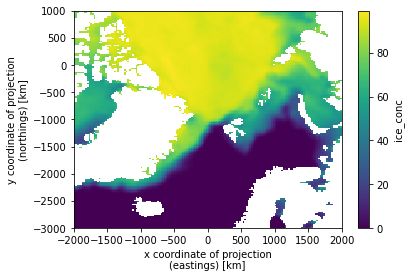

In [28]:
data_merged.sel(time='2000').mean(dim='time').plot(xlim=[-2000,2000], ylim=[-3000,1000])

In [2]:
years = np.arange(2000, 2010, 1)
array = []
for y in years:
    data = xr.open_dataset(f'data/sea_ice_conc/ice_conc_{y}.nc')
    array.append(data)
sea_ice_merged_2009 = xr.concat(array, dim='time')

In [3]:
years = np.arange(2010, 2018, 1)
array = []
for y in years:
    data = xr.open_dataset(f'data/sea_ice_conc/ice_conc_{y}.nc')
    array.append(data)
sea_ice_merged_2017 = xr.concat(array, dim='time')

In [ ]:
sea_ice_merged = xr.concat([sea_ice_merged_2009, sea_ice_merged_2017], dim='time')

In [ ]:
sea_ice_merged

In [308]:
sea_ice_ds = xr.open_mfdataset('data/sea_ice_conc/*.nc', combine='nested', concat_dim='time')

In [310]:
sea_ice_ds

<xarray.Dataset>
Dimensions:   (time: 6574, xc: 432, yc: 432)
Coordinates:
  * time      (time) datetime64[ns] 2000-01-01T12:00:00 ... 2017-12-31T12:00:00
  * xc        (xc) float64 -5.388e+03 -5.362e+03 ... 5.362e+03 5.388e+03
  * yc        (yc) float64 5.388e+03 5.362e+03 ... -5.362e+03 -5.388e+03
    lat       (time, yc, xc) float32 dask.array<chunksize=(322, 216, 216), meta=np.ndarray>
    lon       (yc, xc) float32 dask.array<chunksize=(432, 432), meta=np.ndarray>
Data variables:
    ice_conc  (time, yc, xc) float64 dask.array<chunksize=(365, 432, 432), meta=np.ndarray>
Attributes: (12/40)
    title:                     Sea Ice Concentration Climate Data Record from...
    summary:                   This climate data record of sea ice concentrat...
    topiccategory:             Oceans ClimatologyMeteorologyAtmosphere
    keywords:                  Earth Science > Cryosphere > Sea Ice > Sea Ice...
    keywords_vocabulary:       GCMD Science Keywords
    geospatial_lat_min:        16.62393
    ...                        ...
    tracking_id:               2ac29280-1a8c-4f01-a9a3-0e4cb3027bde
    naming_authority:          int.eumetsat
    Conventions:               CF-1.6 ACDD-1.3
    standard_name_vocabulary:  CF Standard Name Table (v36, 21 September 2016)
    id:                        10.15770/EUM_SAF_OSI_0008
    product_version:           2.0

In [29]:
sea_ice_ds.lat

<xarray.DataArray 'lat' (yc: 432, xc: 432)>
dask.array<getitem, shape=(432, 432), dtype=float32, chunksize=(216, 216), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 2000-01-01T12:00:00
  * xc       (xc) float64 -5.388e+03 -5.362e+03 ... 5.362e+03 5.388e+03
  * yc       (yc) float64 5.388e+03 5.362e+03 ... -5.362e+03 -5.388e+03
    lat      (yc, xc) float32 dask.array<chunksize=(216, 216), meta=np.ndarray>
    lon      (yc, xc) float32 dask.array<chunksize=(432, 432), meta=np.ndarray>
Attributes:
    units:          degrees_north
    long_name:      latitude coordinate
    standard_name:  latitude

In [11]:
def transform_lat_lon_to_xy(lat, lon):
    # Example - your x and y coordinates are in a Lambert Conformal projection
    data_crs = ccrs.LambertAzimuthalEqualArea(central_latitude=90.0)
    # Transform the point - src_crs is always Plate Carree for lat/lon grid
    x, y = data_crs.transform_point(lon, lat, src_crs=ccrs.PlateCarree()) 
    x = x /(10**3)
    y = y /(10**3)
    return x, y

In [ ]:
def find_var_on_Lambert_Azimuthal_Grid(ds, var='ice_conc', lat = 80.0, lon = 100.0):
    # Find indices where lon and lat are closest to point-of-interest.
    idxs = (np.abs(ds.lon - lon) + np.abs(ds.lat - lat)).argmin(dim = ["xc", "yc"])

    # Retrieve value of variable at indices
    value = ds[var].isel(idxs).values

    # Check the actual lat and lon
    lat_in_ds = ds.lat.isel(idxs).values
    lon_in_ds = ds.lon.isel(idxs).values

    # Print some results.
    print(f"Thickness at ({lat_in_ds:.3f}, {lon_in_ds:.3f}) = {value[0]} {ds[var].units}.")
    return value[0]

In [207]:
# Function
def ice_trend_data(xr_ice, xc_min, xc_max, yc_min, yc_max, months):
    xr_ice_coords_limited = xr_ice.sel(xc=slice(xc_min, xc_max)).sel(yc=slice(yc_min, yc_max))
    months_bool = xr_ice['time'].dt.month.isin(months)
    xr_ice_month_coords_limited = xr_ice.isel(time=months_bool)
    
    ice_years = np.unique(xr_ice.time.dt.year)
    ice_years_limited = []
    for i, y in enumerate(ice_years):
        try:
            ice_year_limited =  xr_ice_month_coords_limited.sel(time=str(y)).mean(dim='time').variables['ice_conc'][:,:]
            ice_years_limited.append(ice_year_limited)
        except:
            ice_years = np.delete(ice_years, i)

        
    
    ice_years_array_limited = np.array(ice_years_limited)
   
    df_limited = pd.DataFrame(ice_years_array_limited.reshape(len(ice_years_array_limited), -1), index=ice_years.tolist())
    
    
    final_df_limited = df_limited.apply(pd.Series)
    final_df_limited[np.isnan(final_df_limited)] = 0
    
    x_order_limited = np.arange(1, len(ice_years)+1, 1)
    slopes_limited = []
    for i in np.arange(25600):
        slope_limited = scipy.stats.mstats.theilslopes(y=final_df_limited.iloc[:,i], x=x_order_limited)[0]
        slopes_limited.append(slope_limited)
        np_slopes_limited = np.array(slopes_limited)
        if i % 1000 == 0:
    
    np_slopes_2d_limited = np_slopes_limited.reshape(160, 160)
    
    return np_slopes_2d_limited

In [209]:
ice_summer = ice_trend_data(sea_ice_ds, xc_min=-2000, xc_max=2000, yc_min=-3000, yc_max=1000, months=[5,6,7])

[2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017]
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000


In [239]:
sea_ice_ds

<xarray.Dataset>
Dimensions:   (time: 6574, xc: 432, yc: 432)
Coordinates:
  * time      (time) datetime64[ns] 2000-01-01T12:00:00 ... 2017-12-31T12:00:00
  * xc        (xc) float64 -5.388e+03 -5.362e+03 ... 5.362e+03 5.388e+03
  * yc        (yc) float64 5.388e+03 5.362e+03 ... -5.362e+03 -5.388e+03
    lat       (time, yc, xc) float32 dask.array<chunksize=(322, 216, 216), meta=np.ndarray>
    lon       (yc, xc) float32 dask.array<chunksize=(432, 432), meta=np.ndarray>
Data variables:
    ice_conc  (time, yc, xc) float64 dask.array<chunksize=(365, 432, 432), meta=np.ndarray>
Attributes: (12/40)
    title:                     Sea Ice Concentration Climate Data Record from...
    summary:                   This climate data record of sea ice concentrat...
    topiccategory:             Oceans ClimatologyMeteorologyAtmosphere
    keywords:                  Earth Science > Cryosphere > Sea Ice > Sea Ice...
    keywords_vocabulary:       GCMD Science Keywords
    geospatial_lat_min:        16.62393
    ...                        ...
    tracking_id:               2ac29280-1a8c-4f01-a9a3-0e4cb3027bde
    naming_authority:          int.eumetsat
    Conventions:               CF-1.6 ACDD-1.3
    standard_name_vocabulary:  CF Standard Name Table (v36, 21 September 2016)
    id:                        10.15770/EUM_SAF_OSI_0008
    product_version:           2.0

In [282]:
def ice_trend_plot(slopes_2d, title, cb_label, xc_min, xc_max, yc_min, yc_max, xr_ice): 
    xr_ice_coords_limited = xr_ice.sel(yc=slice(yc_max, yc_min)).sel(xc=slice(xc_min, xc_max))
    
    
    print(xr_ice_coords_limited)
    
    proj = ccrs.LambertAzimuthalEqualArea(central_latitude=90.0) #what projection is the data in
    fig = plt.figure(figsize=(15,5)) #size
    ax = plt.axes(projection=proj)     
    # ease_extent =  [xc_min, xc_max, yc_min, yc_max] #lon and lat max min   
    # ax.set_extent(ease_extent, crs=proj) 

    ax.gridlines(linestyle='--',color='black')    
    data = slopes_2d
    gridlons, gridlats = np.meshgrid(np.array(xr_ice_coords_limited['xc']),np.array(xr_ice_coords_limited['yc'])) 
    
    gridlons, gridlats = np.meshgrid(np.linspace(1, 160, 160), np.linspace(1,60,160))
    
    mapped_grid = ax.pcolormesh(gridlons, gridlats, data, transform=proj, 
                                cmap='bwr')    
    
    # plt.title(str(var)+' time: '+str(time_index), size=14)
    ax.coastlines(resolution="50m", linewidth=1)
    #customise your colourbar
    # cb = plt.colorbar(mapped_grid, orientation="vertical", pad=0.02, extend='both',
    #                  aspect=16, shrink=0.8, format=ticker.FuncFormatter(fmt))
    # cb.set_label('Trend in sea ice concentration in summer [%]', rotation=270, labelpad=15, size=16)
    # cb.ax.tick_params(labelsize=15)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

<xarray.Dataset>
Dimensions:   (time: 6574, xc: 160, yc: 160)
Coordinates:
  * time      (time) datetime64[ns] 2000-01-01T12:00:00 ... 2017-12-31T12:00:00
  * xc        (xc) float64 -1.988e+03 -1.962e+03 ... 1.962e+03 1.988e+03
  * yc        (yc) float64 987.5 962.5 937.5 ... -2.962e+03 -2.988e+03
    lat       (time, yc, xc) float32 dask.array<chunksize=(322, 40, 80), meta=np.ndarray>
    lon       (yc, xc) float32 dask.array<chunksize=(160, 160), meta=np.ndarray>
Data variables:
    ice_conc  (time, yc, xc) float64 dask.array<chunksize=(365, 160, 160), meta=np.ndarray>
Attributes: (12/40)
    title:                     Sea Ice Concentration Climate Data Record from...
    summary:                   This climate data record of sea ice concentrat...
    topiccategory:             Oceans ClimatologyMeteorologyAtmosphere
    keywords:                  Earth Science > Cryosphere > Sea Ice > Sea Ice...
    keywords_vocabulary:       GCMD Science Keywords
    geospatial_lat_min:        16.6

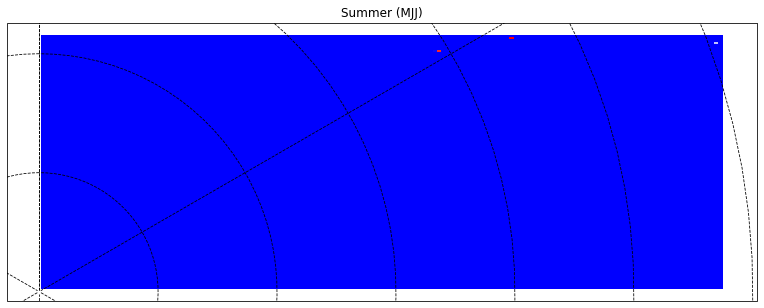

In [283]:
ice_trend_plot(ice_summer, title='Summer (MJJ)', cb_label='Sea ice conc in summer', xc_min=-2000, xc_max=2000, yc_min=-3000, yc_max=1000, 
               xr_ice=sea_ice_ds)

In [5]:
def find_var_on_Lambert_Azimuthal_Grid(ds, var='ice_conc', lat = 80.0, lon = 100.0):
    # Find indices where lon and lat are closest to point-of-interest.
    idxs = (np.abs(ds.lon - lon) + np.abs(ds.lat - lat)).argmin(dim = ["xc", "yc"])

    # Retrieve value of variable at indices
    value = ds[var].isel(idxs).values

    # Check the actual lat and lon
    lat_in_ds = ds.lat.isel(idxs).values
    lon_in_ds = ds.lon.isel(idxs).values

    # Print some results.
    print(f"Thickness at ({lat_in_ds:.3f}, {lon_in_ds:.3f}) = {value[0]} {ds[var].units}.")
    return value[0]


In [6]:
def transform_lat_lon_to_xy(lat, lon):
    # Example - your x and y coordinates are in a Lambert Conformal projection
    data_crs = ccrs.LambertAzimuthalEqualArea(central_latitude=90.0)
    # Transform the point - src_crs is always Plate Carree for lat/lon grid
    x, y = data_crs.transform_point(lon, lat, src_crs=ccrs.PlateCarree()) 
    x = x /(10**3)
    y = y /(10**3)
    return x, y

In [307]:
transform_lat_lon_to_xy(80,100)

(1098.4634811644182, 193.68874905223157)

In [290]:
sea_ice_ds['xc'].max()

<xarray.DataArray 'xc' ()>
array(5387.5)

In [10]:
find_var_on_Lambert_Azimuthal_Grid(sea_ice_merged_2009, lat = 80.0, lon = 0)

Thickness at (80.026, -0.644) = 70.98 %.


70.98